In [1]:
import root_pandas as rp
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import ROOT
import array
import matplotlib
from matplotlib import rc #for custom label formatting
'''Make larger axes labels for plots for papers and such'''
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams["figure.titlesize"] = 30
plt.rc('legend', fontsize=18)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('axes', labelsize=26)
plt.rc('axes', titlesize=26)

Welcome to JupyROOT 6.22/02


In [24]:
#B = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_events.root', key='B')

e = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons.root',key='e')
mu = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons.root',key='mu')
truth_e = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons.root',key='e_truth')
truth_mu = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons.root',key='mu_truth')
truth_B = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons.root',key='B_truth')
e2 = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons2.root',key='e')
mu2 = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons2.root',key='mu')
truth_e2 = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons2.root',key='e_truth')
truth_mu2 = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons2.root',key='mu_truth')
truth_B2 = rp.read_root('/home/jeff/data/thesis_data/combined_reco_ntuples/merged_leptons2.root',key='B_truth')

# Test Lepton ID

In [287]:
#e_red = e.loc[(e['muIDBelleQuality']<0.9) & (e['eIDBelle']>0.2)]
#mu_red = mu.loc[(mu['muIDBelleQuality']>0.9) & (mu['muIDBelle']>0.4) & (mu['eIDBelle']<0.2)]
#e_red2 = e2.loc[(e2['muIDBelleQuality']<0.9) & (e2['eIDBelle']>0.2)]
#mu_red2 = mu2.loc[(mu2['muIDBelleQuality']>0.9) & (mu2['muIDBelle']>0.4) & (mu2['eIDBelle']<0.2)]
#e_red = e.loc[(e['muIDBelle']!=1) & (e['eIDBelle']!=0) & (e['eIDBelle']<0.9999)] # USE THIS FOR LARGE MISTAG FRACZ\
#mu_red = mu.loc[(mu['muIDBelle']!=0) & (mu['eIDBelle']!=1) & (mu['muIDBelle']<0.992)]
e_red = e.loc[(e['muIDBelle']!=1) & (e['eIDBelle']>0.001)] # USE THIS FOR LARGE MISTAG FRACZ\
mu_red = mu.loc[(mu['muIDBelle']>0.01) & (mu['eIDBelle']<0.999)]
e_red2 = e2.loc[(e2['muIDBelle']!=1) & (e2['eIDBelle']>0.001)] # USE THIS FOR LARGE MISTAG FRACZ\
mu_red2 = mu2.loc[(mu2['muIDBelle']>0.01) & (mu2['eIDBelle']<0.999)]

In [288]:
esig_orig = e.loc[e['isSignal']==1]
ebg_orig = e.loc[e['isSignal']!=1]
esig_red = e_red.loc[e_red['isSignal']==1]
ebg_red = e_red.loc[e_red['isSignal']!=1]

In [289]:
len(esig_red)/len(e_red)
#len(esig_red)/len(esig_orig)

0.9673658699649006

In [290]:
musig_orig = mu.loc[mu['isSignal']==1]
mubg_orig = mu.loc[mu['isSignal']!=1]
musig_red = mu_red.loc[mu_red['isSignal']==1]
mubg_red = mu_red.loc[mu_red['isSignal']!=1]

In [291]:
len(musig_red)/len(mu_red)
#len(musig_red)/len(musig_orig)
#len(mubg_red)/len(mu_red)

0.9407582938388626

In [292]:
lepton = e_red.append(mu_red).sort_values(by='__event__')
lepton2 = e_red2.append(mu_red2).sort_values(by='__event__')

In [293]:
def create_lepton_analysis_dataframe(df = lepton, Bs = truth_B):
    df['counts/event'] = 1 #placeholder to select on events with 2 reconstructed dfs
    tab = pd.pivot_table(df, values='counts/event', index=['__event__'], aggfunc=np.sum) #determine # of dfs in event
    tab.loc[tab['counts/event'] == 2].index.to_numpy() #only keep event numbers with 2 reconstructed dfs
    pairs = df.loc[df['__event__'].isin(tab.loc[tab['counts/event']==2].index.to_numpy())] #dataframe with event-wise pairs of dfs
    pairs['truth_dz'] = Bs.loc[Bs['__event__'].isin(pairs['__event__'].to_numpy())]['mcDecayVertexFromIPZ'].to_numpy()
    pairs['B_PDG'] = Bs.loc[Bs['__event__'].isin(pairs['__event__'].to_numpy())]['mcPDG'].to_numpy()
    tmp = pairs.groupby('__event__').diff() #group by differences of events to get quantities like deltaT and to determine mistag
    tmp.dropna(subset = ['z'], inplace = True)
    tmp.index = [i for i in range(0,len(tmp))]
    tmp['deltaT'] = tmp['dz']/(0.425*3e10)*1e12
    tmp['mcDeltaT'] = tmp['truth_dz']/(0.425*3e10)*1e12
    tmp['deltaT'] = np.abs(tmp['deltaT'])
    tmp['mcDeltaT'] = np.abs(tmp['mcDeltaT'])
    tmp['mistag'] = 0
    index = tmp.loc[((tmp['charge']==0) & (tmp['B_PDG']!=0)) | ((tmp['charge']!=0) & (tmp['B_PDG']==0))].index.to_numpy()
    tmp['mistag'][index] = 1
    tmp['SF']=0
    tmp['OF']=0
    tmp['SF_truth']=0
    tmp['OF_truth']=0
    index1 = tmp.loc[tmp['charge']==0].index.to_numpy()
    index2 = tmp.loc[tmp['charge']!=0].index.to_numpy()
    tindex1 = tmp.loc[tmp['B_PDG']==0].index.to_numpy()
    tindex2 = tmp.loc[tmp['B_PDG']!=0].index.to_numpy()
    tmp['SF'][index1]=1
    tmp['OF'][index2]=1
    tmp['SF_truth'][tindex1]=1
    tmp['OF_truth'][tindex2]=1
    tmp['counts'] = 1 #to count events in grouped bins
    test = tmp.groupby(pd.cut(tmp['deltaT'],bins = [0,0.5] + [i for i in range(1,7)] + [7,9,13,20])).sum()
    test_err = np.sqrt(tmp.groupby(pd.cut(tmp['deltaT'],bins = [0,0.5] + [i for i in range(1,7)] + [7,9,13,20])).sum())
    test_truth = tmp.groupby(pd.cut(tmp['mcDeltaT'],bins = [0,0.5] + [i for i in range(1,7)] + [7,9,13,20])).sum()
    test_truth_err = np.sqrt(tmp.groupby(pd.cut(tmp['mcDeltaT'],bins = [0,0.5] + [i for i in range(1,7)] + [7,9,13,20])).sum())
    test['A'] = (test['OF']-test['SF'])/(test['OF']+test['SF'])
    test_err['A'] = np.abs(test['A'])*np.sqrt((np.sqrt(test_err['OF']**2+test_err['SF']**2)/(test['OF']-test['SF']))**2 + (np.sqrt(test_err['OF']**2+test_err['SF']**2)/(test['OF']+test['SF']))**2)
    test['A_truth'] = (test['OF_truth']-test['SF_truth'])/(test['OF_truth']+test['SF_truth'])
    test_err['A_truth'] = np.abs(test['A_truth'])*np.sqrt((np.sqrt(test_err['OF_truth']**2+test_err['SF_truth']**2)/(test['OF_truth']-test['SF_truth']))**2 + (np.sqrt(test_err['OF_truth']**2+test_err['SF_truth']**2)/(test['OF_truth']+test['SF_truth']))**2)
    test_truth['A'] = (test_truth['OF']-test_truth['SF'])/(test_truth['OF']+test_truth['SF'])
    test_truth_err['A'] = np.abs(test_truth['A'])*np.sqrt((np.sqrt(test_truth_err['OF']**2+test_truth_err['SF']**2)/(test_truth['OF']-test_truth['SF']))**2 + (np.sqrt(test_truth_err['OF']**2+test_truth_err['SF']**2)/(test_truth['OF']+test_truth['SF']))**2)
    test_truth['A_truth'] = (test_truth['OF_truth']-test_truth['SF_truth'])/(test_truth['OF_truth']+test_truth['SF_truth'])
    test_truth_err['A_truth'] = np.abs(test_truth['A_truth'])*np.sqrt((np.sqrt(test_truth_err['OF_truth']**2+test_truth_err['SF_truth']**2)/(test_truth['OF_truth']-test_truth['SF_truth']))**2 + (np.sqrt(test_truth_err['OF_truth']**2+test_truth_err['SF_truth']**2)/(test_truth['OF_truth']+test_truth['SF_truth']))**2)
    
    return tmp, test[['OF','SF','OF_truth','SF_truth','A','A_truth','counts','mistag']], test_err[['OF','SF','OF_truth','SF_truth','A','A_truth','counts','mistag']], test_truth[['OF','SF','OF_truth','SF_truth','A','A_truth','counts','mistag']], test_truth_err[['OF','SF','OF_truth','SF_truth','A','A_truth','counts','mistag']]

data, deltaT, deltaT_err, truth_deltaT, truth_deltaT_err = create_lepton_analysis_dataframe(lepton, truth_B)
data2, deltaT2, deltaT_err2, truth_deltaT2, truth_deltaT_err2 = create_lepton_analysis_dataframe(lepton2, truth_B2)
signal = e.loc[e['isSignal']==1].append(mu.loc[mu['isSignal']==1]).sort_values(by='__event__')
signal2 = e2.loc[e2['isSignal']==1].append(mu2.loc[mu2['isSignal']==1]).sort_values(by='__event__')
truth = create_lepton_analysis_dataframe(signal, truth_B)[0]
truth2 = create_lepton_analysis_dataframe(signal2, truth_B2)[0]

/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://panda

/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/home/jeff/anaconda3/envs/root_env/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [ ]:
def root_fit(plot_data, A, A_err): #fits cosine curve to data (asymmetry computed from binning)
    x1 = array.array('d', [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5])
    y = array.array('d', A)
    xerr = array.array('d', [0 for i in range(0,len(x1))])
    #xerr = array.array('d', [0.25, 0.25, 0.5, 0.5 ,0.5, 0.5, 0.5, 0.5, 1, 2, 3.5])
    yerr = array.array('d', A_err)
    gr = ROOT.TGraphErrors(len(x1), x1, y, xerr, yerr)
    f = ROOT.TF1('f1', '[0]*cos(0.496*x)', 0, 16.5)
    gr.Fit('f1', 'SMRB')
    fitdict = {"Amp":f.GetParameter(0), "Amp_err":f.GetParError(0)}
    return fitdict

e_cut = [e.loc[(e['muIDBelle']!=1) & (e['eIDBelle']!=0) & (e['eIDBelle']<0.9999)], e.loc[(e['muIDBelle']!=1) & (e['eIDBelle']!=0) & (e['eIDBelle']<0.999)],
         e.loc[(e['muIDBelle']<0.9) & (e['eIDBelle']>0.1)], e.loc[(e['muIDBelleQuality']<0.9) & (e['eIDBelle']>0.2)],
        e.loc[(e['muIDBelle']!=1) & (e['eIDBelle']!=0) & (e['eIDBelle']<0.9975)],e.loc[(e['muIDBelle']!=1) & (e['eIDBelle']!=0) & (e['eIDBelle']<0.99)],
        e.loc[(e['muIDBelle']!=1) & (e['eIDBelle']!=0) & (e['eIDBelle']<0.96)], e.loc[(e['muIDBelle']<0.99) & (e['eIDBelle']>0.01) & (e['eIDBelle']<0.99)],
        e.loc[(e['muIDBelle']<0.99) & (e['eIDBelle']>0.01) & (e['eIDBelle']<0.987)],e.loc[(e['muIDBelle']<0.99) & (e['eIDBelle']>0.01) & (e['eIDBelle']<0.985)]]


mu_cut = [mu.loc[(mu['muIDBelle']!=0) & (mu['eIDBelle']!=1) & (mu['muIDBelle']<0.99)], mu.loc[(mu['muIDBelle']!=0) & (mu['eIDBelle']!=1) & (mu['muIDBelle']<0.98)],
         mu.loc[(mu['muIDBelle']<0.0) & (mu['eIDBelle']>0.1)], mu.loc[(mu['muIDBelleQuality']>0.9) & (mu['muIDBelle']>0.4) & (mu['eIDBelle']<0.2)],
         mu.loc[(mu['muIDBelle']!=0) & (mu['eIDBelle']!=1) & (mu['muIDBelle']<0.972)],mu.loc[(mu['muIDBelle']!=0) & (mu['eIDBelle']!=1) & (mu['muIDBelle']<0.96)],
         mu.loc[(mu['muIDBelle']!=0) & (mu['eIDBelle']!=1) & (mu['muIDBelle']<0.9)], mu.loc[(mu['muIDBelle']>0.01) & (mu['eIDBelle']<0.99) & (mu['muIDBelle']<0.999)],
         mu.loc[(mu['muIDBelle']>0.01) & (mu['eIDBelle']<0.99) & (mu['muIDBelle']<0.997)],mu.loc[(mu['muIDBelle']>0.01) & (mu['eIDBelle']<0.99) & (mu['muIDBelle']<0.995)]]
mistags = []
amplitude = []
amplitude_err = []
truth_amp = []
truth_amp_err = []

for i in range(0,len(e_cut)):
    lepton = e_cut[i].append(mu_cut[i]).sort_values(by='__event__')
    data, deltaT, deltaT_err, truth_deltaT, truth_deltaT_err = create_lepton_analysis_dataframe(lepton)
    fit_values = root_fit(data,truth_deltaT['A'],truth_deltaT_err['A'])
    mistag_frac = len(data.loc[data['mistag']==1])/len(data)
    mistags.append(mistag_frac)
    amplitude.append(fit_values['Amp'])
    amplitude_err.append(fit_values['Amp_err'])
    truth_fits = root_fit(data,truth_deltaT['A_truth'],truth_deltaT_err['A_truth'])
    truth_amp.append(truth_fits['Amp'])
    truth_amp_err.append(truth_fits['Amp_err'])

In [ ]:
mistags = np.array(mistags)
amplitude = np.array(amplitude)
amplitude_err = np.array(amplitude_err)
truth_amp = np.array(truth_amp)
truth_amp_err = np.array(truth_amp_err)

In [ ]:
mistags

In [ ]:
def fit_line(x,y,y_err): #fits cosine curve to data (asymmetry computed from binning)
    x1 = array.array('d', x)
    y = array.array('d', y)
    xerr = array.array('d', [0 for i in range(0,len(x1))])
    #xerr = array.array('d', [0.25, 0.25, 0.5, 0.5 ,0.5, 0.5, 0.5, 0.5, 1, 2, 3.5])
    yerr = array.array('d', y_err)
    gr = ROOT.TGraphErrors(len(x1), x1, y, xerr, yerr)
    f = ROOT.TF1('f1', '[0]+[1]*x')
    gr.Fit('f1', 'SB')
    fitdict = {"Int":f.GetParameter(0), "Int_err": f.GetParError(0), "Slope":f.GetParameter(1)
               ,"Slope_err": f.GetParError(1), 'chi2': f.GetChisquare(), 'NDF': f.GetNDF()}
    return fitdict

plt.figure(figsize=(12,8))
x=np.linspace(0,0.5,101)
plt.errorbar(mistags,amplitude,amplitude_err,None,'o',markersize=5,markeredgecolor='k',color= 'red')
plt.plot(x,1-2*x,color='k',linestyle='--',alpha = 0.3, label=r'$1-2w$')
plt.xlim(0,0.5)
plt.ylim(0,1)
plt.xlabel('w')
plt.ylabel('Asymm. fit amplitude')
plt.legend(fancybox=True,shadow=True)
plt.grid()
fit = fit_line(mistags,amplitude,amplitude_err)
print(fit)
#plt.savefig('assymmetry_summary.png',dpi=300,bbox_inches='tight')

In [ ]:
plt.hist(data['dz'],range = (-0.25,0.25), bins = 50, histtype='step',label = 'reco')
plt.hist(data['truth_dz'],range = (-0.25,0.25), bins = 50,histtype='step',label='truth')
plt.legend()

In [294]:
dataSF = data.loc[data['SF']==1]
dataOF = data.loc[data['SF']!=1]
tmpSF = truth.loc[truth['SF']==1]
tmpOF = truth.loc[truth['SF']!=1]
dataSF2 = data2.loc[data2['SF']==1]
dataOF2 = data2.loc[data2['SF']!=1]
tmpSF2 = truth2.loc[truth2['SF']==1]
tmpOF2 = truth2.loc[truth2['SF']!=1]

In [295]:
response_OF = ROOT.RooUnfoldResponse (15, 0, 15)
response_SF = ROOT.RooUnfoldResponse (15, 0, 15)

In [296]:
fOF = ROOT.TH1F("fOF","fOF",15,0,15)
gOF = ROOT.TH1F("gOF","gOF",15,0,15)
fSF = ROOT.TH1F("fSF","fSF",15,0,15)
gSF = ROOT.TH1F("gSF","gSF",15,0,15)

Warning in <TROOT::Append>: Replacing existing TH1: fOF (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: gOF (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fSF (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: gSF (Potential memory leak).


# Use one dataset and truth set to fill response matrices

In [297]:
for i in range(0,min(len(dataOF),len(tmpOF))):
    fOF.Fill(tmpOF['mcDeltaT'].iloc[i])
    gOF.Fill(dataOF['deltaT'].iloc[i])
    response_OF.Fill(dataOF['deltaT'].iloc[i],tmpOF['mcDeltaT'].iloc[i])
for i in range(0,min(len(dataSF),len(tmpSF))):
    fSF.Fill(tmpSF['mcDeltaT'].iloc[i])
    gSF.Fill(dataSF['deltaT'].iloc[i])
    response_SF.Fill(dataSF['deltaT'].iloc[i],tmpSF['mcDeltaT'].iloc[i])

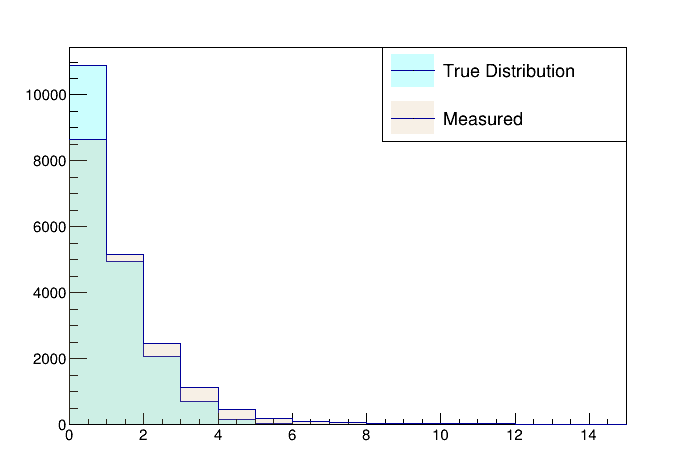

In [298]:
c = ROOT.TCanvas()
fOF.SetStats(0)
fOF.SetTitle("")
fOF.SetFillColorAlpha(7,0.2)
fOF.Draw()
gOF.SetFillColorAlpha(42,0.2)
gOF.Draw("same")
leg = ROOT.TLegend(.55,0.7,.9,.9)
leg.AddEntry(fOF,"True Distribution")
leg.AddEntry(gOF,"Measured")
leg.Draw()
c.Draw()

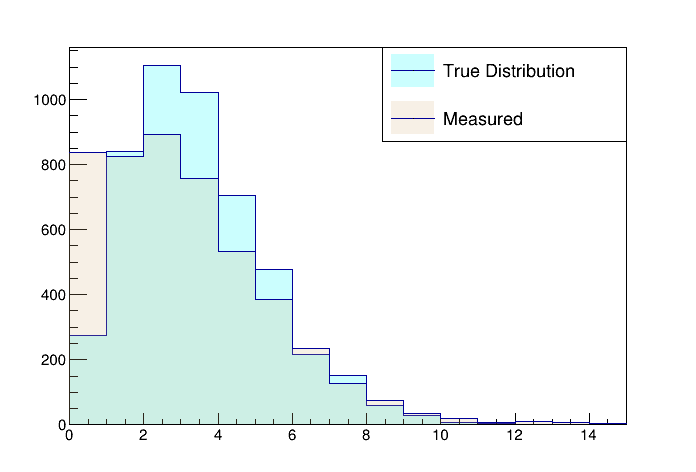

In [299]:
c1 = ROOT.TCanvas()
fSF.SetStats(0)
fSF.SetTitle("")
fSF.SetFillColorAlpha(7,0.2)
fSF.Draw()
gSF.SetFillColorAlpha(42,0.2)
gSF.Draw("same")
leg = ROOT.TLegend(.55,0.7,.9,.9)
leg.AddEntry(fSF,"True Distribution")
leg.AddEntry(gSF,"Measured")
leg.Draw()
c1.Draw()

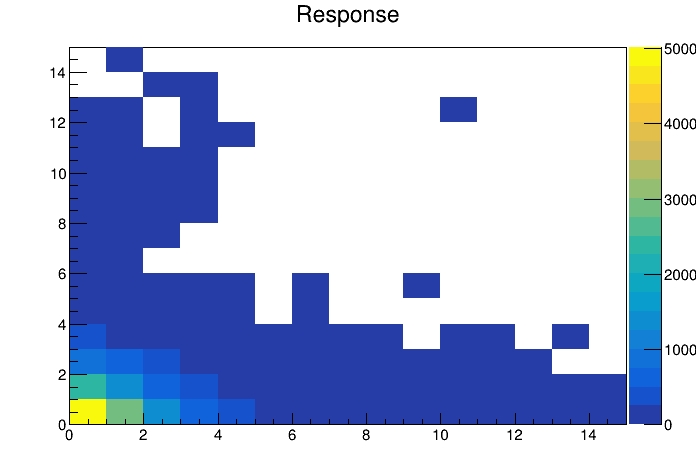

In [300]:
ROF = response_OF.HresponseNoOverflow()
c2 = ROOT.TCanvas()
ROF.SetStats(0)
ROF.Draw("colz")
c2.Draw()

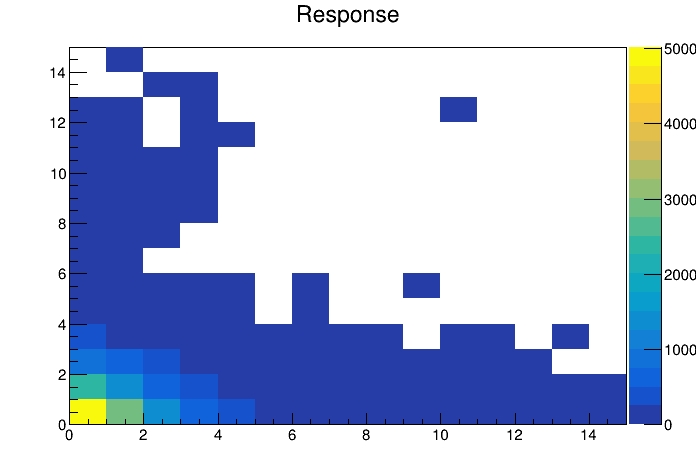

In [301]:
RSF = response_OF.HresponseNoOverflow()
c3 = ROOT.TCanvas()
RSF.SetStats(0)
RSF.Draw("colz")
c3.Draw()

# USe different data and truth sets for testing

In [302]:
hTrueOF = ROOT.TH1D ("trueOF", "Test Truth",    15, 0, 15)
hMeasOF = ROOT.TH1D ("measOF", "Test Measured", 15, 0, 15)
hTrueSF = ROOT.TH1D ("trueSF", "Test Truth",    15, 0, 15)
hMeasSF = ROOT.TH1D ("measSF", "Test Measured", 15, 0, 15)

for i in range(0,min(len(dataOF2),len(tmpOF2))):
    xt = tmpOF2['mcDeltaT'].to_numpy()[i]
    x = np.abs(dataOF2['deltaT']).to_numpy()[i]
    hTrueOF.Fill(xt)
    hMeasOF.Fill(x)
for i in range(0,min(len(dataSF2),len(tmpSF2))):
    xt = tmpSF2['mcDeltaT'].to_numpy()[i]
    x = np.abs(dataSF2['deltaT']).to_numpy()[i]
    hTrueSF.Fill(xt)
    hMeasSF.Fill(x)



Warning in <TROOT::Append>: Replacing existing TH1: trueOF (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: measOF (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: trueSF (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: measSF (Potential memory leak).


In [343]:
unfoldOF = ROOT.RooUnfoldBayes(response_OF, hMeasOF, 1)
hRecoOF = unfoldOF.Hreco()

unfoldSF = ROOT.RooUnfoldBayes(response_SF, hMeasSF, 1)
hRecoSF = unfoldSF.Hreco()

Now unfolding...
Iteration : 0
Chi^2 of change 0.00631845
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 0.0147803
Calculating covariances due to number of measured events


In [232]:
#unfoldOF = ROOT.RooUnfoldSvd(response_OF, hMeasOF,2)
#hRecoOF = unfoldOF.Hreco()

#unfoldSF = ROOT.RooUnfoldSvd(response_SF, hMeasSF,2)
#hRecoSF = unfoldSF.Hreco()

SVD init 12 x 12 bins, kreg=2
SVD init 12 x 12 bins, kreg=2


Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.318482
Info in <TSVDUnfold_130729::Unfold>: Unfolding param: 2
Info in <TSVDUnfold_130729::Unfold>: Curvature of weight distribution: 0.008749


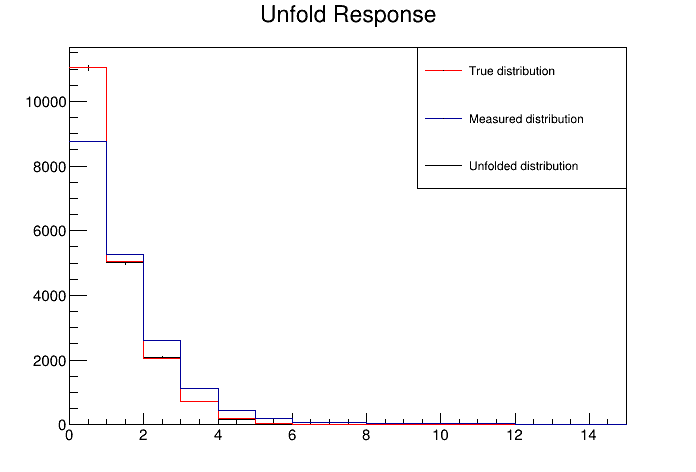

In [344]:
c1 = ROOT.TCanvas()
hRecoOF.SetStats(0)
hTrueOF.SetLineColor(2)
hRecoOF.SetLineColor(1)
hRecoOF.Draw()
hTrueOF.Draw("same")
hMeasOF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueOF, "True distribution","pl")
leg.AddEntry(hMeasOF, "Measured distribution", "pl")
leg.AddEntry(hRecoOF, "Unfolded distribution")
leg.Draw()
c1.Draw()

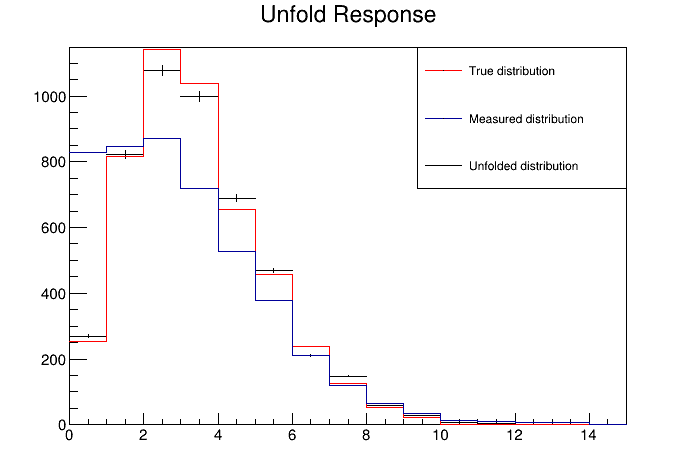

In [345]:
c1 = ROOT.TCanvas()
hRecoSF.SetStats(0)
hTrueSF.SetLineColor(2)
hRecoSF.SetLineColor(1)
hRecoSF.Draw()
hTrueSF.Draw("same")
hMeasSF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueSF, "True distribution","pl")
leg.AddEntry(hMeasSF, "Measured distribution", "pl")
leg.AddEntry(hRecoSF, "Unfolded distribution")
leg.Draw()
c1.Draw()

In [333]:
mistag = 1-2*len(data2.loc[data2['mistag']==1])/len(data2)

In [351]:
vals = []
vals_meas = []
vals_truth = []
for i in range(1,14):
    vals.append((hRecoOF.GetBinContent(i)-hRecoSF.GetBinContent(i))/(hRecoOF.GetBinContent(i)+hRecoSF.GetBinContent(i)))
    vals_truth.append((hTrueOF.GetBinContent(i)-hTrueSF.GetBinContent(i))/(hTrueOF.GetBinContent(i)+hTrueSF.GetBinContent(i)))
    vals_meas.append((hMeasOF.GetBinContent(i)-hMeasSF.GetBinContent(i))/(hMeasOF.GetBinContent(i)+hMeasSF.GetBinContent(i)))
           

In [352]:
vals_err = []
vals_meas_err = []
vals_truth_err = []
for i in range(1,14):
    vals_err.append(np.abs(vals[i-1])*np.sqrt((np.sqrt(hRecoOF.GetBinError(i)**2 + hRecoSF.GetBinError(i))/(hRecoOF.GetBinContent(i)-hRecoSF.GetBinContent(i)))**2+(np.sqrt(hRecoOF.GetBinError(i)**2 + hRecoSF.GetBinError(i))/(hRecoOF.GetBinContent(i)+hRecoSF.GetBinContent(i)))**2))
    vals_truth_err.append(np.abs(vals_truth[i-1])*np.sqrt((np.sqrt(hTrueOF.GetBinError(i)**2 + hTrueSF.GetBinError(i))/(hTrueOF.GetBinContent(i)-hTrueSF.GetBinContent(i)))**2+(np.sqrt(hTrueOF.GetBinError(i)**2 + hTrueSF.GetBinError(i))/(hTrueOF.GetBinContent(i)+hTrueSF.GetBinContent(i)))**2))
    vals_meas_err.append(np.abs(vals_meas[i-1])*np.sqrt((np.sqrt(hMeasOF.GetBinError(i)**2 + hMeasSF.GetBinError(i))/(hMeasOF.GetBinContent(i)-hMeasSF.GetBinContent(i)))**2+(np.sqrt(hMeasOF.GetBinError(i)**2 + hMeasSF.GetBinError(i))/(hMeasOF.GetBinContent(i)+hMeasSF.GetBinContent(i)))**2))

In [348]:
1-2*len(data2.loc[data2['mistag']==1])/len(data2)

0.9035300902088397

<ErrorbarContainer object of 3 artists>

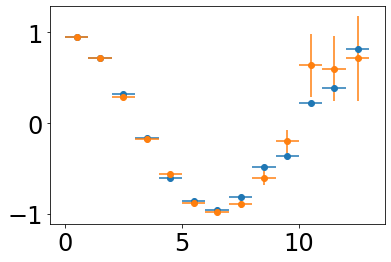

In [353]:
x = [i+0.5 for i in range(0,13)]
xerr = [0.5 for i in range(0,13)]
plt.errorbar(x,vals,vals_err,xerr,'o')
plt.errorbar(x,vals_truth,vals_truth_err,xerr,'o')
#plt.errorbar(x,vals_meas,vals_meas_err,xerr,'o')

In [364]:
def root_fit(A, A_err): #fits cosine curve to data (asymmetry computed from binning)
    x1 = array.array('d', [i+0.5 for i in range(0,13)])
    y = array.array('d', A)
    xerr = array.array('d', [0.5 for i in range(0,13)])
    #xerr = array.array('d', [0.25, 0.25, 0.5, 0.5 ,0.5, 0.5, 0.5, 0.5, 1, 2, 3.5])
    yerr = array.array('d', A_err)
    gr = ROOT.TGraphErrors(len(x1), x1, y, xerr, yerr)
    f = ROOT.TF1('f1', '[0]*cos([1]*x)', 0, 15)
    f.SetParLimits(0,0,1)
    f.SetParLimits(1,0,1)
    gr.Fit('f1', 'SMRB')
    fitdict = {"amp":f.GetParameter(0), "amp_err":f.GetParError(0),
              "md":f.GetParameter(1), 'md_err':f.GetParError(1)}
    return fitdict

In [365]:
print(root_fit(vals,vals_err))
#print(root_fit(vals_meas,vals_meas_err))
print(root_fit(vals_truth,vals_truth_err))

{'amp': 0.6250445169808061, 'amp_err': 0.007646982084573262, 'md': 0.6941685124369403, 'md_err': 0.0013330582077139552}
{'amp': 0.9999999999999996, 'amp_err': 0.004323599876991824, 'md': 1.0, 'md_err': 5.08802052944235e-05}
 FCN=537.711 FROM HESSE     STATUS=OK             10 CALLS         174 TOTAL
                     EDM=1.07051e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.25045e-01   7.64698e-03   5.58284e-06  -9.80916e-04
   2  p1           6.94169e-01   1.33306e-03   5.11875e-06   5.37538e-02
 FCN=414.818 FROM HESSE     STATUS=OK             12 CALLS         156 TOTAL
                     EDM=1.50121e-12    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.00000e+

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 9), sharex = True, gridspec_kw={'hspace': 0.03, 'height_ratios': [3,1]})
centers = [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5]
widths = np.array([0.25, 0.25, 0.5, 0.5 ,0.5, 0.5, 0.5, 0.5, 1, 2, 3.5])
ax[0].errorbar(centers,truth_deltaT['A_truth'],truth_deltaT_err['A_truth'],widths, 'o', label = r"Truth B")
ax[0].errorbar(centers,truth_deltaT['A'],truth_deltaT_err['A'],widths, 'o', label = r"Reconstructed lepton: mistag frac %s"%(round(len(data.loc[data['mistag']==1])/len(data),4)))
#ax[0].errorbar(centers, 1/(1-2*len(data.loc[data['mistag']==1])/len(data))*truth_deltaT['A'], 1/(1-2*len(data.loc[data['mistag']==1])/len(data))*truth_deltaT_err['A'], widths, 'o', label=r'Scaled reconstructed lepton')

go = np.array([1.013, 0.916, 0.699, 0.339, -0.136, -0.634, -0.961, -0.974, -0.675, 0.089, 0.243])
go_err = np.array([0.028, 0.022, 0.038, 0.056, 0.075, 0.084, 0.077, 0.080, 0.109, 0.193, 0.435])
#plt.errorbar(centers,go,go_err,widths, 'o', label = "Go's result")

x = np.linspace(0,17,201)
ax[0].plot(x, np.cos(0.496*x), 'k', linestyle = '--', label=r'QM expectation $\Delta m_d = 0.496$',alpha = 0.3)
#plt.plot(x, np.cos(0.4496*x), 'red', linestyle = '--', label='SD least squares fit to truth MC')
ax[1].bar(centers,truth_deltaT['mistag']/truth_deltaT['counts'],2*widths)
ax[0].set_ylabel(r'$\mathcal{A}(\Delta_{m_d}\Delta t)$')
ax[1].set_ylabel(r'$w$')
ax[1].set_xlabel(r'$\Delta t_\mathrm{truth}$ [ps]')
ax[0].grid()
ax[1].grid()
ax[0].legend(bbox_to_anchor=(.23,0.95),fancybox=True,shadow=True)
#plt.savefig('asymmetry_mistag_small.png', bbox_inches = 'tight', dpi = 300)

In [ ]:
def root_fit(plot_data, A, A_err): #fits cosine curve to data (asymmetry computed from binning)
    x1 = array.array('d', [0.25,0.75,1.5,2.5,3.5,4.5,5.5,6.5,8,11,16.5])
    y = array.array('d', A)
    xerr = array.array('d', [0 for i in range(0,len(x1))])
    #xerr = array.array('d', [0.25, 0.25, 0.5, 0.5 ,0.5, 0.5, 0.5, 0.5, 1, 2, 3.5])
    yerr = array.array('d', A_err)
    gr = ROOT.TGraphErrors(len(x1), x1, y, xerr, yerr)
    f = ROOT.TF1('f1', '[0]*cos(0.496*x)', 0, 16.5)
    gr.Fit('f1', 'SMRB')
    fitdict = {"Amp":f.GetParameter(0), "Amp_err":f.GetParError(0)}
    return fitdict

In [ ]:
root_fit(data,truth_deltaT['A'],truth_deltaT_err['A'])

In [ ]:
root_fit(data,truth_deltaT['A_truth'],truth_deltaT_err['A_truth'])

In [ ]:
1-2*len(data.loc[data['mistag']==1])/len(data)

## Dump

In [ ]:
c1 = ROOT.TCanvas()
hRecoSF.SetStats(0)
hTrueSF.SetLineColor(2)
hRecoSF.SetLineColor(1)
hRecoSF.Draw()
hTrueSF.Draw("same")
hMeasSF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueSF, "True distribution","pl")
leg.AddEntry(hMeasSF, "Measured distribution", "pl")
leg.AddEntry(hRecoSF, "Unfolded distribution")
leg.Draw()
c1.Draw()

unfoldOF = ROOT.RooUnfoldInvert(response_OF, hMeasOF)
hRecoOF = unfoldOF.Hreco()

unfoldSF = ROOT.RooUnfoldInvert(response_SF, hMeasSF)
hRecoSF = unfoldSF.Hreco()

c1 = ROOT.TCanvas()
hRecoOF.SetStats(0)
hTrueOF.SetLineColor(2)
hRecoOF.SetLineColor(1)
hRecoOF.Draw()
hTrueOF.Draw("same")
hMeasOF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueOF, "True distribution","pl")
leg.AddEntry(hMeasOF, "Measured distribution", "pl")
leg.AddEntry(hRecoOF, "Unfolded distribution")
leg.Draw()
c1.Draw()

c1 = ROOT.TCanvas()
hRecoSF.SetStats(0)
hTrueSF.SetLineColor(2)
hRecoSF.SetLineColor(1)
hRecoSF.Draw()
hTrueSF.Draw("same")
hMeasSF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueSF, "True distribution","pl")
leg.AddEntry(hMeasSF, "Measured distribution", "pl")
leg.AddEntry(hRecoSF, "Unfolded distribution")
leg.Draw()
c1.Draw()

unfoldOF = ROOT.RooUnfoldBinByBin(response_OF, hMeasOF)
hRecoOF = unfoldOF.Hreco()
c1 = ROOT.TCanvas()
hRecoOF.SetStats(0)
hRecoOF.SetTitle("")
hTrueOF.SetLineColor(2)
hRecoOF.SetLineColor(1)
hRecoOF.Draw()
hTrueOF.Draw("same")
hMeasOF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueOF, "True distribution","pl")
leg.AddEntry(hMeasOF, "Measured distribution", "pl")
leg.AddEntry(hRecoOF, "Unfolded distribution")
leg.Draw()
c1.Draw()

unfoldSF = ROOT.RooUnfoldBinByBin(response_SF, hMeasSF)
hRecoSF = unfoldSF.Hreco()
c1 = ROOT.TCanvas()
hRecoSF.SetStats(0)
hRecoSF.SetTitle("")
hTrueSF.SetLineColor(2)
hRecoSF.SetLineColor(1)
hRecoSF.Draw()
hTrueSF.Draw("same")
hMeasSF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueSF, "True distribution","pl")
leg.AddEntry(hMeasSF, "Measured distribution", "pl")
leg.AddEntry(hRecoSF, "Unfolded distribution")
leg.Draw()
c1.Draw()

unfoldOF = ROOT.RooUnfoldBayes(response_OF, hMeasOF, 2)
hRecoOF = unfoldOF.Hreco()

unfoldSF = ROOT.RooUnfoldBayes(response_SF, hMeasSF, 2)
hRecoSF = unfoldSF.Hreco()

c1 = ROOT.TCanvas()
hRecoSF.SetStats(0)
hTrueSF.SetLineColor(2)
hRecoSF.SetLineColor(1)
hRecoSF.Draw()
hTrueSF.Draw("same")
hMeasSF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueSF, "True distribution","pl")
leg.AddEntry(hMeasSF, "Measured distribution", "pl")
leg.AddEntry(hRecoSF, "Unfolded distribution")
leg.Draw()
c1.Draw()

c1 = ROOT.TCanvas()
hRecoOF.SetStats(0)
hTrueOF.SetLineColor(2)
hRecoOF.SetLineColor(1)
hRecoOF.Draw()
hTrueOF.Draw("same")
hMeasOF.Draw("same")
leg = ROOT.TLegend(0.6, 0.6, 0.9, 0.9)
leg.AddEntry(hTrueOF, "True distribution","pl")
leg.AddEntry(hMeasOF, "Measured distribution", "pl")
leg.AddEntry(hRecoOF, "Unfolded distribution")
leg.Draw()
c1.Draw()
